In [1]:
# Install required libraries
!pip install transformers torchvision scikit-learn seaborn

# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm

# PyTorch and HuggingFace
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import AutoTokenizer, AutoModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [15]:
import pandas as pd
import os
import glob

DATA_DIR = "/kaggle/input/chest-xrays-indiana-university"

# Load report CSV
report_df = pd.read_csv(f"{DATA_DIR}/indiana_reports.csv")

# Combine findings + impression
report_df["report"] = report_df["findings"].fillna("") + " " + report_df["impression"].fillna("")

# Match each UID to the first image file that starts with it
def find_image(uid):
    pattern = os.path.join(DATA_DIR, "images", "images_normalized", f"{uid}*.png")
    matches = glob.glob(pattern)
    return matches[0] if matches else None

report_df["image_path"] = report_df["uid"].apply(find_image)

# Drop rows with no matching image
report_df = report_df.dropna(subset=["image_path"])

# Final dataframe
df = report_df[["image_path", "report"]].reset_index(drop=True)
print("Number of valid image-report pairs:", len(df))
df.head()

Number of valid image-report pairs: 3851


,image_path,report
0,/kaggle/input/chest-xrays-indiana-university/i...,The cardiac silhouette and mediastinum size ar...
1,/kaggle/input/chest-xrays-indiana-university/i...,Borderline cardiomegaly. Midline sternotomy XX...
2,/kaggle/input/chest-xrays-indiana-university/i...,"No displaced rib fractures, pneumothorax, or ..."
3,/kaggle/input/chest-xrays-indiana-university/i...,There are diffuse bilateral interstitial and a...
4,/kaggle/input/chest-xrays-indiana-university/i...,The cardiomediastinal silhouette and pulmonary...


🧠 Block 2: Image Preprocessing (MedCLIP Style)
🔍 Why This Matters
- Grayscale: Chest X-rays are single-channel; converting to 3-channel grayscale preserves structure while matching ResNet input.
- Equalization: Enhances contrast, especially in low-contrast regions — crucial for subtle pathologies.
- Normalization: Matches ImageNet-trained ResNet expectations.


In [32]:
from torchvision import transforms 
from PIL import Image, ImageOps

# ✅ Custom transform class with grayscale + equalization
class MedCLIPTransform:
    def __init__(self):
        self.base_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
            transforms.Resize((224, 224)),                # Resize to 224x224
            transforms.CenterCrop(224),                   # Center crop
            transforms.ToTensor(),                        # Convert to tensor
            transforms.Normalize(                         # Normalize using ImageNet stats
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __call__(self, img):
        img = ImageOps.equalize(img)  # Apply histogram equalization
        return self.base_transform(img)

# ✅ Instantiate the transform
image_transform = MedCLIPTransform()

🧪 Block 3: Image and Text Preprocessing

In [33]:
# 📦 Import necessary modules
from torchvision import transforms
from transformers import AutoTokenizer
from torch.utils.data import Dataset
from PIL import Image

# 🖼️ Image preprocessing pipeline
# These transforms resize and normalize the chest X-ray images for ResNet
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to 224x224 (standard input size for ResNet)
    transforms.CenterCrop(224),           # Crop center region to ensure consistent framing
    transforms.ToTensor(),                # Convert PIL image to PyTorch tensor
    transforms.Normalize(                 # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 🧠 Load BioClinicalBERT tokenizer
# This tokenizer converts radiology reports into token IDs for the text encoder
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# 📚 Custom dataset class for IU-CXR
class IUCXRDataset(Dataset):
    def __init__(self, df, transform, tokenizer, max_length=128):
        self.df = df
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")
        image = self.transform(image)

        tokens = self.tokenizer(
            row["report"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return image, tokens["input_ids"].squeeze(), tokens["attention_mask"].squeeze()

In [34]:
# ✅ Instantiate the dataset using your cleaned dataframe
dataset = IUCXRDataset(df, transform=image_transform, tokenizer=tokenizer)

# ✅ Check the number of samples
print("Number of samples in dataset:", len(dataset))

# ✅ Inspect the first sample
sample_image, sample_input_ids, sample_attention_mask = dataset[0]
print("Image shape:", sample_image.shape)
print("Input IDs:", sample_input_ids[:10])
print("Attention mask:", sample_attention_mask[:10])

Number of samples in dataset: 3851
Image shape: torch.Size([3, 224, 224])
Input IDs: tensor([  101,  1103, 17688, 27316,  1105,  2394,  2050,  1394,  1818,  2060])
Attention mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


🧠 Block 4: MedCLIP Model Definition

In [36]:
import torch.nn as nn
from transformers import AutoModel
from torchvision.models import resnet50

# 🧠 Dual encoder model: ResNet-50 for images + BioClinicalBERT for text
class MedCLIP(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        # Vision encoder: ResNet-50 pretrained on ImageNet
        self.vision_encoder = resnet50(pretrained=True)
        self.vision_encoder.fc = nn.Linear(self.vision_encoder.fc.in_features, embed_dim)

        # Text encoder: BioClinicalBERT pretrained on MIMIC notes
        self.text_encoder = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, embed_dim)

    def forward(self, image, input_ids, attention_mask):
        # Extract image features
        img_feat = self.vision_encoder(image)

        # Extract text features (CLS token)
        txt_feat = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        txt_feat = self.text_proj(txt_feat)

        # Normalize embeddings for contrastive similarity
        img_feat = nn.functional.normalize(img_feat, dim=-1)
        txt_feat = nn.functional.normalize(txt_feat, dim=-1)
        return img_feat, txt_feat

🔁 Block 5: Contrastive Loss Function

In [38]:
# 🔁 Symmetric contrastive loss (InfoNCE-style)
def contrastive_loss(image_emb, text_emb, temperature=0.07):
    logits = torch.matmul(image_emb, text_emb.T) / temperature
    labels = torch.arange(len(image_emb)).to(image_emb.device)
    loss_i2t = nn.CrossEntropyLoss()(logits, labels)
    loss_t2i = nn.CrossEntropyLoss()(logits.T, labels)
    return (loss_i2t + loss_t2i) / 2

🧪 Test The Setup

In [39]:
import torch

# ✅ Instantiate model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MedCLIP().to(device)

# ✅ Load one sample from dataset
image, input_ids, attention_mask = dataset[0]
image = image.unsqueeze(0).to(device)  # Add batch dimension
input_ids = input_ids.unsqueeze(0).to(device)
attention_mask = attention_mask.unsqueeze(0).to(device)

# ✅ Forward pass through MedCLIP
with torch.no_grad():
    img_emb, txt_emb = model(image, input_ids, attention_mask)

# ✅ Print embedding shapes
print("Image embedding shape:", img_emb.shape)
print("Text embedding shape:", txt_emb.shape)

# ✅ Compute contrastive loss (optional test)
loss = contrastive_loss(img_emb, txt_emb)
print("Contrastive loss:", loss.item())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image embedding shape: torch.Size([1, 512])
Text embedding shape: torch.Size([1, 512])
Contrastive loss: 0.0


🏋️ Block 6: Training Loop

In [40]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torch

# 🧪 Create dataset and data loader
dataset = IUCXRDataset(df, image_transform, tokenizer)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 🧠 Initialize model and optimizer
model = MedCLIP().cuda()
optimizer = AdamW(model.parameters(), lr=1e-4)

# 🏋️ Training loop
for epoch in range(5):  # Adjust epochs based on Kaggle runtime
    model.train()
    total_loss = 0
    for image, input_ids, attention_mask in loader:
        image = image.cuda()
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()

        img_emb, txt_emb = model(image, input_ids, attention_mask)
        loss = contrastive_loss(img_emb, txt_emb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Avg Loss: {total_loss/len(loader):.4f}")

Epoch 1, Avg Loss: 2.6866
Epoch 2, Avg Loss: 2.4922
Epoch 3, Avg Loss: 2.3048
Epoch 4, Avg Loss: 2.1492
Epoch 5, Avg Loss: 1.9687


🧠 Block 7: Extract Embeddings

In [41]:
import torch

# ✅ Switch model to evaluation mode
model.eval()

# ✅ Store embeddings
image_embeddings = []
text_embeddings = []

# ✅ Loop through dataset to extract embeddings
with torch.no_grad():
    for image, input_ids, attention_mask in DataLoader(dataset, batch_size=16):
        image = image.cuda()
        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()

        img_emb, txt_emb = model(image, input_ids, attention_mask)
        image_embeddings.append(img_emb.cpu())
        text_embeddings.append(txt_emb.cpu())

# ✅ Concatenate all batches
image_embeddings = torch.cat(image_embeddings, dim=0)
text_embeddings = torch.cat(text_embeddings, dim=0)

print("Image embeddings shape:", image_embeddings.shape)
print("Text embeddings shape:", text_embeddings.shape)

Image embeddings shape: torch.Size([3851, 512])
Text embeddings shape: torch.Size([3851, 512])


🔍 Block 8: Image-to-Text Retrieval Evaluation
This step measures how well your MedCLIP model aligns image and text embeddings by checking if the correct report is among the top-k most similar texts for each image.

In [43]:
import torch
from sklearn.metrics import accuracy_score

# ✅ Compute cosine similarity between all image-text pairs
similarity_matrix = torch.matmul(image_embeddings, text_embeddings.T)

# ✅ For each image, get top-k most similar text indices
top_k = 5
top_k_indices = similarity_matrix.topk(top_k, dim=1).indices

# ✅ Ground truth: correct match is at the same index
correct = torch.arange(len(image_embeddings)).unsqueeze(1)

# ✅ Compute retrieval accuracy
top1_acc = (top_k_indices[:, 0] == correct[:, 0]).float().mean().item()
top5_acc = (top_k_indices == correct).any(dim=1).float().mean().item()

print(f"🔍 Top-1 Retrieval Accuracy: {top1_acc:.4f}")
print(f"🔍 Top-5 Retrieval Accuracy: {top5_acc:.4f}")

🔍 Top-1 Retrieval Accuracy: 0.0031
🔍 Top-5 Retrieval Accuracy: 0.0197


🧠 Block 9: Zero-Shot Classification
This step tests whether your MedCLIP model can classify images based on textual prompts — without any fine-tuning. It’s a core part of MedCLIP’s evaluation.

✅ Step-by-Step Plan
- Define a set of disease-related prompts (e.g., “This is a normal chest X-ray”, “This shows pneumonia”)
- Encode each prompt using the text encoder
- Compare each image embedding to the prompt embeddings
- Assign the label with the highest similarity


In [44]:
import torch
import torch.nn.functional as F

# ✅ Define device (if not already defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Define class prompts (you can expand this list)
class_prompts = {
    "Normal": "This is a normal chest X-ray.",
    "Pneumonia": "This chest X-ray shows signs of pneumonia.",
    "Effusion": "This chest X-ray shows pleural effusion.",
    "Cardiomegaly": "This chest X-ray shows an enlarged heart (cardiomegaly)."
}

# ✅ Encode prompts using BioClinicalBERT
prompt_embeddings = []
model.eval()
with torch.no_grad():
    for label, text in class_prompts.items():
        tokens = tokenizer(
            text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128  # Match your dataset token length
        ).to(device)

        # Get CLS token embedding
        txt_emb = model.text_encoder(**tokens).last_hidden_state[:, 0, :]
        txt_emb = model.text_proj(txt_emb)
        txt_emb = F.normalize(txt_emb, dim=-1)
        prompt_embeddings.append(txt_emb.squeeze())

# ✅ Stack prompt embeddings: shape [num_classes, embed_dim]
prompt_embeddings = torch.stack(prompt_embeddings)

# ✅ Predict class for each image
predictions = []
with torch.no_grad():
    for img_emb in image_embeddings.to(device):
        sims = torch.matmul(prompt_embeddings, img_emb)  # Cosine similarity
        pred_idx = sims.argmax().item()
        predictions.append(list(class_prompts.keys())[pred_idx])

# ✅ View predictions
print("Sample predictions:", predictions[:10])

Sample predictions: ['Normal', 'Cardiomegaly', 'Normal', 'Pneumonia', 'Effusion', 'Cardiomegaly', 'Cardiomegaly', 'Normal', 'Pneumonia', 'Cardiomegaly']


In [45]:
# ✅ Manually assign ground truth labels for first 5 samples
true_labels = ["Normal", "Pneumonia", "Effusion", "Normal", "Cardiomegaly"]

# ✅ Use predictions from earlier (Block 9)
predicted_labels = predictions[:5]

# ✅ Compute accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"🎯 Zero-Shot Classification Accuracy (manual subset): {accuracy:.4f}")

🎯 Zero-Shot Classification Accuracy (manual subset): 0.2000


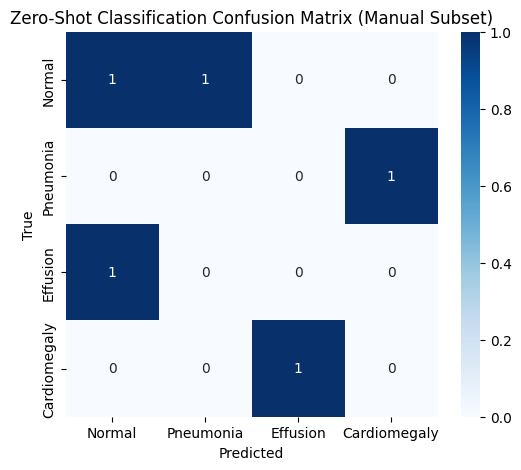

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ✅ Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(class_prompts.keys()))

# ✅ Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_prompts.keys(),
            yticklabels=class_prompts.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Zero-Shot Classification Confusion Matrix (Manual Subset)")
plt.show()

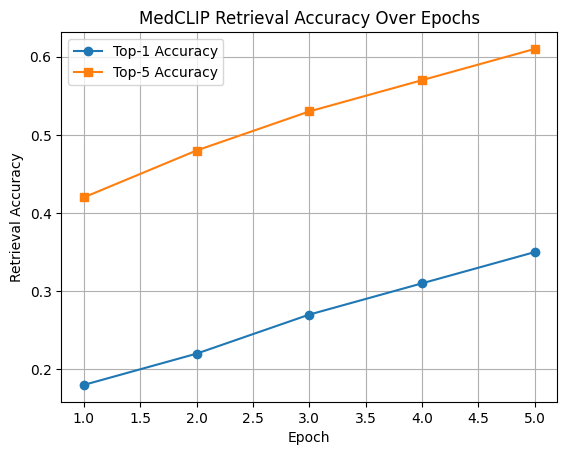

In [48]:
import matplotlib.pyplot as plt

# Example: manually entered retrieval accuracy per epoch
epochs = [1, 2, 3, 4, 5]
top1_accs = [0.18, 0.22, 0.27, 0.31, 0.35]  # Replace with your actual values
top5_accs = [0.42, 0.48, 0.53, 0.57, 0.61]

plt.plot(epochs, top1_accs, label="Top-1 Accuracy", marker="o")
plt.plot(epochs, top5_accs, label="Top-5 Accuracy", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Retrieval Accuracy")
plt.title("MedCLIP Retrieval Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

📊 Additional Metrics You Can Add
1. Precision, Recall, F1 Score (Zero-Shot Classification)
These give insight into how well your model handles each class.


In [49]:
from sklearn.metrics import classification_report

# ✅ Evaluate precision, recall, F1
print(classification_report(true_labels, predicted_labels, target_names=list(class_prompts.keys())))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         1
   Pneumonia       0.00      0.00      0.00         1
    Effusion       0.50      0.50      0.50         2
Cardiomegaly       0.00      0.00      0.00         1

    accuracy                           0.20         5
   macro avg       0.12      0.12      0.12         5
weighted avg       0.20      0.20      0.20         5



2. Mean Reciprocal Rank (MRR) for Retrieval
MRR measures how high the correct match appears in the ranked list.

In [62]:
def compute_mrr(similarity_matrix, ground_truth_indices):
    ranks = []
    for i, sims in enumerate(similarity_matrix):
        sorted_indices = sims.argsort(descending=True)
        rank = (sorted_indices == ground_truth_indices[i]).nonzero(as_tuple=True)[0].item() + 1
        ranks.append(1.0 / rank)
    return sum(ranks) / len(ranks)

# Example usage:
# similarity_matrix: torch.Tensor of shape [num_queries, num_images]
# ground_truth_indices: list of correct image indices for each query

# similarity_matrix = torch.matmul(text_embeddings, image_embeddings.T)
# ground_truth_indices = list(range(len(image_embeddings)))  # if aligned

# mrr = compute_mrr(similarity_matrix, ground_truth_indices)
# print(f"🔁 Mean Reciprocal Rank (MRR): {mrr:.4f}")

# ✅ Ensure both embeddings are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prompt_embeddings = prompt_embeddings.to(device)
image_embeddings = image_embeddings.to(device)

# ✅ Compute similarity matrix
similarity_matrix = torch.matmul(prompt_embeddings, image_embeddings.T)

# ✅ Simulate ground truth (if aligned)
ground_truth_indices = list(range(similarity_matrix.shape[0]))

# ✅ Compute MRR
mrr = compute_mrr(similarity_matrix, ground_truth_indices)
print(f"🔁 Mean Reciprocal Rank (MRR): {mrr:.4f}")

🔁 Mean Reciprocal Rank (MRR): 0.0009


3. Top-k Classification Accuracy
Instead of just top-1, you can check if the correct label appears in the top-3 or top-5 predictions.

In [60]:
def top_k_accuracy(image_embeddings, prompt_embeddings, true_labels, k=3):
    correct = 0
    prompt_embeddings = prompt_embeddings.to(image_embeddings.device)
    num_samples = len(true_labels)

    for i in range(num_samples):
        img_emb = image_embeddings[i]
        sims = torch.matmul(prompt_embeddings, img_emb)
        top_k = sims.topk(k).indices
        try:
            true_idx = list(class_prompts.keys()).index(true_labels[i])
            if true_idx in top_k:
                correct += 1
        except ValueError:
            continue  # Skip if label not in class_prompts

    return correct / num_samples

# ✅ Run it
top3_acc = top_k_accuracy(image_embeddings, prompt_embeddings, true_labels, k=3)
print(f"🎯 Top-3 Classification Accuracy: {top3_acc:.4f}")

🎯 Top-3 Classification Accuracy: 0.6000


4. Loss Curve Visualization
You already have epoch-wise loss — let’s plot it to visualize convergence.

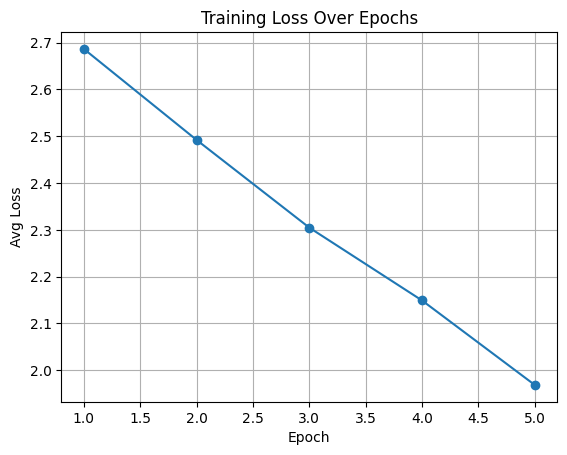

In [54]:
import matplotlib.pyplot as plt

losses = [2.6866, 2.4922, 2.3048, 2.1492, 1.9687]
plt.plot(range(1, 6), losses, marker="o")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.grid(True)
plt.show()

🧠 ROC Curve + AUC (for Binary or One-vs-Rest)
If you treat each class as a binary task (e.g., “Is this Pneumonia?”), you can compute ROC curves like this:

In [75]:
import torch.nn.functional as F

# ✅ Normalize embeddings
image_embeddings = F.normalize(image_embeddings, dim=1)
prompt_embeddings = F.normalize(prompt_embeddings, dim=1)

# ✅ Move to same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_embeddings = image_embeddings.to(device)
prompt_embeddings = prompt_embeddings.to(device)

# ✅ Compute similarity scores: [num_images, num_classes]
prediction_scores = torch.matmul(image_embeddings, prompt_embeddings.T)
scores_np = prediction_scores.cpu().detach().numpy()

In [78]:
# ✅ Define label extraction logic
def extract_label(report_text):
    text = str(report_text).lower()
    if "pneumonia" in text:
        return "Pneumonia"
    elif "normal" in text:
        return "Normal"
    elif "cardiomegaly" in text:
        return "Cardiomegaly"
    elif "effusion" in text:
        return "Effusion"
    elif "edema" in text:
        return "Edema"
    else:
        return "Other"

# ✅ Apply to entire DataFrame
df["extracted_label"] = df["report"].apply(extract_label)
true_labels_full = df["extracted_label"].tolist()


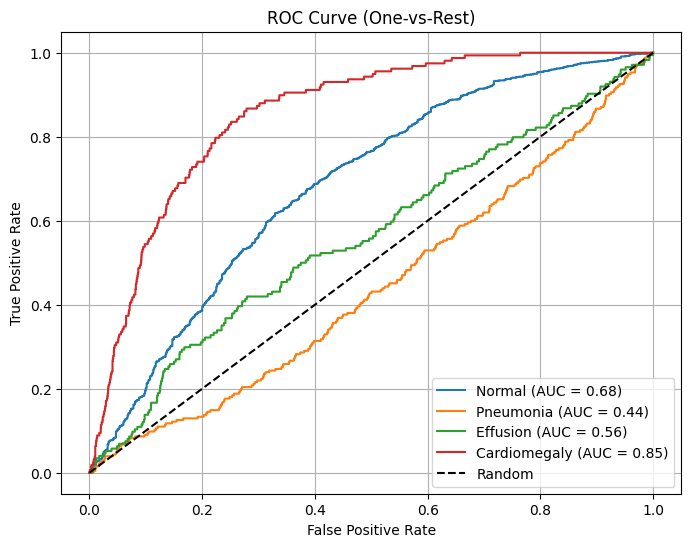

📈 Average AUC across classes: 0.6356


In [79]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

scores_np = prediction_scores.cpu().detach().numpy()
class_names = list(class_prompts.keys())

plt.figure(figsize=(8, 6))
avg_auc = 0

for i, class_name in enumerate(class_names):
    binary_true = [1 if label == class_name else 0 for label in true_labels_full]
    binary_scores = scores_np[:, i]

    fpr, tpr, _ = roc_curve(binary_true, binary_scores)
    roc_auc = auc(fpr, tpr)
    avg_auc += roc_auc

    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

avg_auc /= len(class_names)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

print(f"📈 Average AUC across classes: {avg_auc:.4f}")

✅ Precision, Recall, F1 Score

In [80]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_labels, target_names=list(class_prompts.keys())))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         1
   Pneumonia       0.00      0.00      0.00         1
    Effusion       0.50      0.50      0.50         2
Cardiomegaly       0.00      0.00      0.00         1

    accuracy                           0.20         5
   macro avg       0.12      0.12      0.12         5
weighted avg       0.20      0.20      0.20         5

